In [1]:
import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from fi_nomad.kernels import Momentum3BlockModelFreeKernel, AggressiveMomentumModelFreeKernel, BaseModelFree
from fi_nomad.types import (
    FloatArrayType,
    KernelInputType,
    Momentum3BlockAdditionalParameters,
    AggressiveMomentumAdditionalParameters,
    LossType,
    SVDStrategy,
    InitializationStrategy,
)
from fi_nomad.util import compute_loss

In [3]:
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=5, linewidth=150)

Generate data to decompose (example taken from nomad package tests).

In [4]:
X = np.eye(9) * 3.0
(n, p) = X.shape

In [5]:
target_rank = 5
candidate_W = np.ones((n, target_rank))
candidate_H = np.ones((target_rank, p))
candidate = candidate_W @ candidate_H
svd_strategy = SVDStrategy.RANDOM_TRUNCATED
tolerance = 0.0
indata = KernelInputType(X, candidate, target_rank, svd_strategy, tolerance)


We fit A-NMD and 3B-NMD with no momentum and high momentum.

In [6]:
momentum_beta_low = 0.0
momentum_beta_high = 0.999
n_iters = 250

As well as the base model-free NMD as a baseline.

In [7]:
kernel_base = BaseModelFree(indata)

In [8]:
results_base = {"ZL_loss": [], "XL_loss": []}
for i in range(n_iters):
    kernel_base.step()
    results_base["ZL_loss"].append(kernel_base.loss)
    results_base["XL_loss"].append(
        compute_loss(kernel_base.sparse_matrix_X, 
                     np.maximum(0.0, kernel_base.low_rank_candidate_L)
        )
    )
results_base = pd.DataFrame.from_dict(results_base)

Loss looks fine.

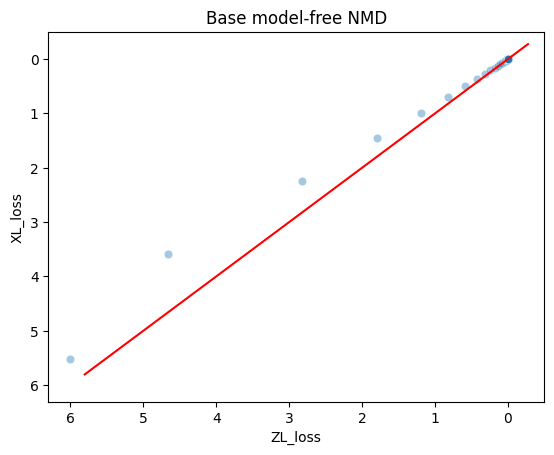

In [9]:
g = sns.scatterplot(results_base, x="ZL_loss", y= "XL_loss", alpha=0.4)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, "-r")
g.set_ylim((lims[1] + 0.5, -0.5))
g.set_xlim((lims[1] + 0.5, -0.5))
g.set_title(f"Base model-free NMD")
plt.show()

Fit 3B-NMD

In [10]:
kernel_3B_no_momentum = Momentum3BlockModelFreeKernel(indata, Momentum3BlockAdditionalParameters(
    momentum_beta=momentum_beta_low,
))

kernel_3B_high_momentum = Momentum3BlockModelFreeKernel(indata, Momentum3BlockAdditionalParameters(
    momentum_beta=momentum_beta_high,
))

In [11]:
results_3BNMD_no_momentum = {"ZL_loss": [], "XL_loss": []}
for i in range(n_iters):
    kernel_3B_no_momentum.step()
    results_3BNMD_no_momentum["ZL_loss"].append(kernel_3B_no_momentum.loss)
    results_3BNMD_no_momentum["XL_loss"].append(
        compute_loss(kernel_3B_no_momentum.sparse_matrix_X, 
                     np.maximum(0.0, kernel_3B_no_momentum.low_rank_candidate_L)
        )
    )
results_3BNMD_no_momentum = pd.DataFrame.from_dict(results_3BNMD_no_momentum)
results_3BNMD_no_momentum["XL_ZL_diff"] = results_3BNMD_no_momentum["XL_loss"] - results_3BNMD_no_momentum["ZL_loss"]

In [12]:
results_3BNMD_high_momentum = {"ZL_loss": [], "XL_loss": []}
for i in range(n_iters):
    kernel_3B_high_momentum.step()
    results_3BNMD_high_momentum["ZL_loss"].append(kernel_3B_high_momentum.loss)
    results_3BNMD_high_momentum["XL_loss"].append(
        compute_loss(kernel_3B_high_momentum.sparse_matrix_X, 
                     np.maximum(0.0, kernel_3B_high_momentum.low_rank_candidate_L)
        )
    )
results_3BNMD_high_momentum = pd.DataFrame.from_dict(results_3BNMD_high_momentum)

The high-momentum 3B-NMD run shows the phenomenon I was refering to.

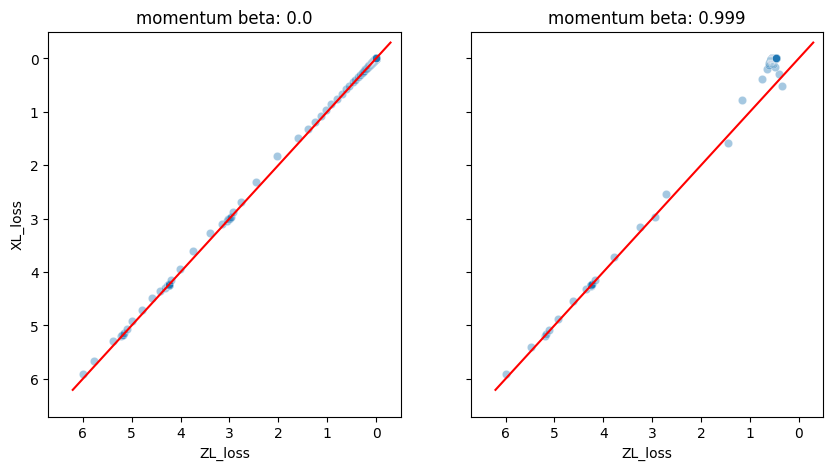

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
g1 = sns.scatterplot(results_3BNMD_no_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax1)
x0, x1 = g1.get_xlim()
y0, y1 = g1.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.plot(lims, lims, "-r")
g1.set_ylim((lims[1] + 0.5, -0.5))
g1.set_xlim((lims[1] + 0.5, -0.5))
g1.set_title(f"3B-NMD with beta: {momentum_beta_low}")

g2 = sns.scatterplot(results_3BNMD_high_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax2)
g2.plot(lims, lims, "-r")
g2.set_title(f"3B-NMD with beta: {momentum_beta_high}")
plt.show()

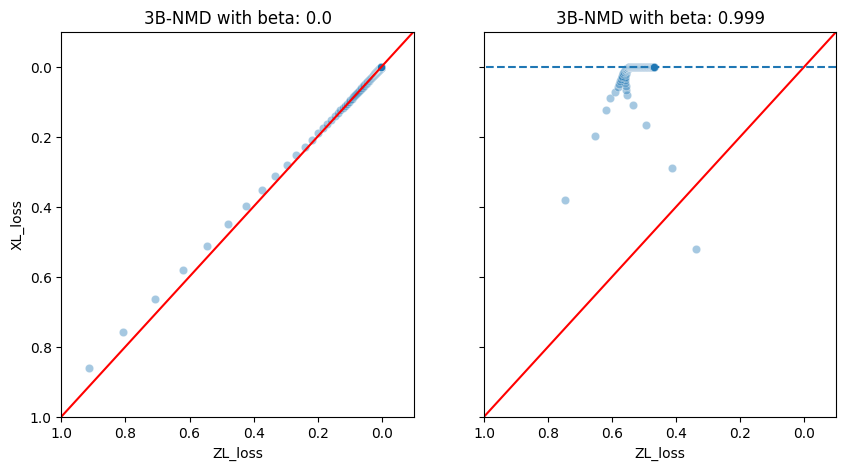

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
g1 = sns.scatterplot(results_3BNMD_no_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax1)
x0, x1 = g1.get_xlim()
y0, y1 = g1.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.plot(lims, lims, "-r")
g1.set_ylim((1, -0.1))
g1.set_xlim((1, -0.1))
g1.set_title(f"3B-NMD with beta: {momentum_beta_low}")

g2 = sns.scatterplot(results_3BNMD_high_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax2)
g2.plot(lims, lims, "-r")
ax2.axhline(y=0.0, xmin=1.0, xmax=-0.5, ls='--')
g2.set_title(f"3B-NMD with beta: {momentum_beta_high}")
plt.show()

Fit A-NMD

In [14]:
kernel_ANMD_no_momentum = AggressiveMomentumModelFreeKernel(indata, AggressiveMomentumAdditionalParameters(
    momentum_beta=momentum_beta_low,
))

kernel_ANMD_high_momentum = AggressiveMomentumModelFreeKernel(indata, AggressiveMomentumAdditionalParameters(
    momentum_beta=momentum_beta_high,
))

In [15]:
results_ANMD_no_momentum = {"ZL_loss": [], "XL_loss": []}
for i in range(n_iters):
    kernel_ANMD_no_momentum.step()
    results_ANMD_no_momentum["ZL_loss"].append(kernel_ANMD_no_momentum.loss)
    results_ANMD_no_momentum["XL_loss"].append(compute_loss(kernel_ANMD_no_momentum.sparse_matrix_X, 
                                                np.maximum(0.0, kernel_ANMD_no_momentum.low_rank_candidate_L)))
results_ANMD_no_momentum = pd.DataFrame.from_dict(results_ANMD_no_momentum)
results_ANMD_no_momentum["XL_ZL_diff"] = results_ANMD_no_momentum["XL_loss"] - results_ANMD_no_momentum["ZL_loss"]

In [16]:
results_ANMD_high_momentum = {"ZL_loss": [], "XL_loss": []}
for i in range(n_iters):
    kernel_ANMD_high_momentum.step()
    results_ANMD_high_momentum["ZL_loss"].append(kernel_ANMD_high_momentum.loss)
    results_ANMD_high_momentum["XL_loss"].append(compute_loss(kernel_ANMD_high_momentum.sparse_matrix_X, 
                                                np.maximum(0.0, kernel_ANMD_high_momentum.low_rank_candidate_L)))
results_ANMD_high_momentum = pd.DataFrame.from_dict(results_ANMD_high_momentum)
results_ANMD_high_momentum["XL_ZL_diff"] = results_ANMD_high_momentum["XL_loss"] - results_ANMD_high_momentum["ZL_loss"]

The issue is less pronounced in the A-NMD runs.

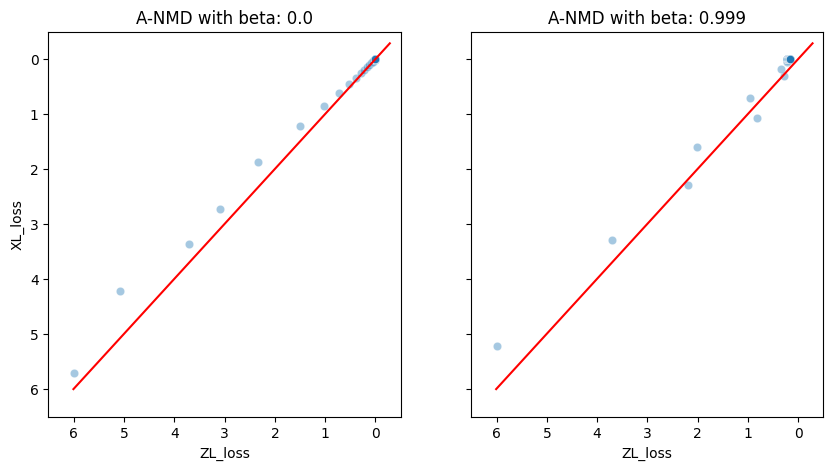

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
g1 = sns.scatterplot(results_ANMD_no_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax1)
x0, x1 = g1.get_xlim()
y0, y1 = g1.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.plot(lims, lims, "-r")
g1.set_ylim((lims[1] + 0.5, -0.5))
g1.set_xlim((lims[1] + 0.5, -0.5))
g1.set_title(f"A-NMD with beta: {momentum_beta_low}")

g2 = sns.scatterplot(results_ANMD_high_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax2)
g2.plot(lims, lims, "-r")
g2.set_title(f"A-NMD with beta: {momentum_beta_high}")
plt.show()

But visible if we zoom in.

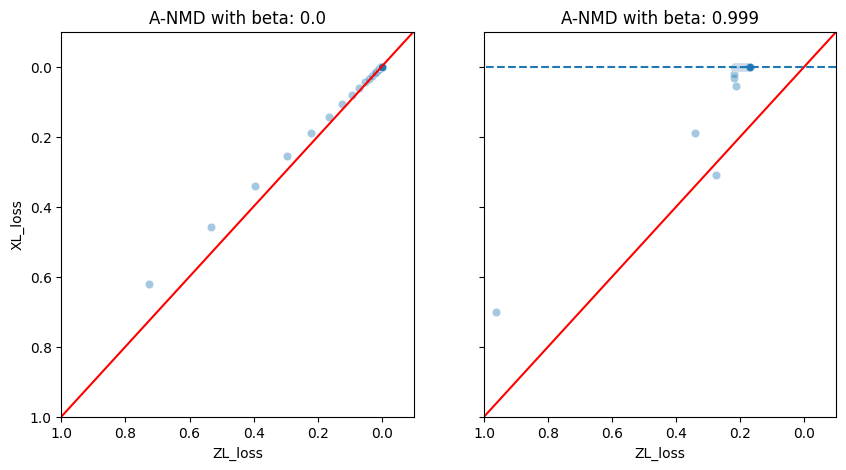

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
g1 = sns.scatterplot(results_ANMD_no_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax1)
x0, x1 = g1.get_xlim()
y0, y1 = g1.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.plot(lims, lims, "-r")
g1.set_ylim((1, -0.1))
g1.set_xlim((1, -0.1))
g1.set_title(f"A-NMD with beta: {momentum_beta_low}")

g2 = sns.scatterplot(results_ANMD_high_momentum, x="ZL_loss", y= "XL_loss", alpha=0.4, ax=ax2)
g2.plot(lims, lims, "-r")
g2.set_title(f"A-NMD with beta: {momentum_beta_high}")
ax2.axhline(y=0.0, xmin=1.0, xmax=-0.5, ls='--')
plt.show()